In [1]:
# --------------- #
# Import Packages #
# --------------- #

# --- Base packages ---
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import geopandas as gpd

# --- Visualisation packages ---
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 8})
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import altair as alt
from pandas.plotting import parallel_coordinates
import plotly.express as px

# --- Statistical packages ---
import math
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# --- Mainly to supress Altair's warnings ---
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **RQ3**: _What are the district characteristics associated with variations in crime?_

---

## A. Preliminaries

### A.1. Restructure the Data

In [2]:
# Import pre-processed census data.
main_df_pre = pd.read_csv("data/0_main_df_pre.csv")
main_df_pre_mod = main_df_pre.copy()
main_df_pre_mod = main_df_pre_mod.drop(columns=main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('age')])
main_df_pre_mod['age_00_09'] = main_df_pre['age_00_04'] + main_df_pre['age_05_09']
main_df_pre_mod['age_10_19'] = main_df_pre['age_10_14'] + main_df_pre['age_15_19']
main_df_pre_mod['age_20_29'] = main_df_pre['age_20_24'] + main_df_pre['age_25_29']
main_df_pre_mod['age_30_39'] = main_df_pre['age_30_34'] + main_df_pre['age_35_39']
main_df_pre_mod['age_40_49'] = main_df_pre['age_40_44'] + main_df_pre['age_45_49']
main_df_pre_mod['age_50_59'] = main_df_pre['age_50_54'] + main_df_pre['age_55_59']
main_df_pre_mod['age_60_69'] = main_df_pre['age_60_64'] + main_df_pre['age_65_69']
main_df_pre_mod['age_70+'] = main_df_pre['age_70_74'] + main_df_pre['age_75_79'] + main_df_pre['age_80_84'] + main_df_pre['age_85+']
main_df_pre_mod = main_df_pre_mod.set_index(['state', 'district']).sort_index()

main_df_post = pd.read_csv("data/0_main_df_post.csv")
main_df_post_mod = main_df_post.copy()
main_df_post_mod = main_df_post_mod.drop(columns=main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('age')])
main_df_post_mod['age_00_09'] = main_df_post['age_00_04'] + main_df_post['age_05_09']
main_df_post_mod['age_10_19'] = main_df_post['age_10_14'] + main_df_post['age_15_19']
main_df_post_mod['age_20_29'] = main_df_post['age_20_24'] + main_df_post['age_25_29']
main_df_post_mod['age_30_39'] = main_df_post['age_30_34'] + main_df_post['age_35_39']
main_df_post_mod['age_40_49'] = main_df_post['age_40_44'] + main_df_post['age_45_49']
main_df_post_mod['age_50_59'] = main_df_post['age_50_54'] + main_df_post['age_55_59']
main_df_post_mod['age_60_69'] = main_df_post['age_60_64'] + main_df_post['age_65_69']
main_df_post_mod['age_70+'] = main_df_post['age_70_74'] + main_df_post['age_75_79'] + main_df_post['age_80_84'] + main_df_post['age_85+']
main_df_post_mod = main_df_post_mod.set_index(['state', 'district']).sort_index()


# Select and normalise variables by district population
main_df_pre_norm = main_df_pre_mod[['population']]
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['population']] / main_df_pre_mod[['population']].sum(), on=['state', 'district'], suffixes=('', '_share'))                                               # Share of total population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('crime')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])           # Crime per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['rate_births', 'rate_deaths']], on=['state', 'district'])                                                                                                # Births and deaths per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('sex')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Proportion of population by gender
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('age')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Proportion of population by age group
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('ethnic')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])          # Proportion of population by age group
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('income')]], on=['state', 'district'])                                                     # Mean/median income and inequality
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('poverty')]], on=['state', 'district'])                                                    # Poverty rate
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[['p_rate', 'u_rate', 'ep_ratio']], on=['state', 'district'])                                                                                              # Labour force data
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('edu')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])             # Students per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('teach')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])           # Teachers per '000 population
main_df_pre_norm = pd.merge(main_df_pre_norm, main_df_pre_mod[main_df_pre_mod.columns[main_df_pre_mod.columns.str.startswith('school')]].div(main_df_pre_mod['population'], axis=0), on=['state', 'district'])          # Schools per '000 population

main_df_post_norm = main_df_post_mod[['population']]
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['population']] / main_df_post_mod[['population']].sum(), on=['state', 'district'], suffixes=('', '_share'))                                           # Share of total population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('crime')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])     # Crime per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['rate_births', 'rate_deaths']], on=['state', 'district'])                                                                                             # Births and deaths per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('sex')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Proportion of population by gender
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('age')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Proportion of population by age group
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('ethnic')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])    # Proportion of population by age group
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('income')]], on=['state', 'district'])                                                # Mean/median income and inequality
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('poverty')]], on=['state', 'district'])                                               # Poverty rate
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[['p_rate', 'u_rate', 'ep_ratio']], on=['state', 'district'])                                                                                           # Labour force data
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('edu')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])       # Students per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('teach')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])     # Teachers per '000 population
main_df_post_norm = pd.merge(main_df_post_norm, main_df_post_mod[main_df_post_mod.columns[main_df_post_mod.columns.str.startswith('school')]].div(main_df_post_mod['population'], axis=0), on=['state', 'district'])    # Schools per '000 population

# Import geo data.
district_boundaries = gpd.read_file('data/district_boundaries.shp')

# Only use values in shapefiles
dfPre = main_df_pre_norm.reset_index()[main_df_pre_norm.reset_index()['district'].isin(district_boundaries.district)]
dfPost = main_df_post_norm.reset_index()[main_df_post_norm.reset_index()['district'].isin(district_boundaries.district)]

# Create East and West Malaysia tag
dfPre['location'] = dfPre['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')
dfPost['location'] = dfPost['state'].apply(lambda x: 'East Malaysia' if np.isin(x, ['Sabah', 'Sarawak', 'W.P. Labuan']) else 'West Malaysia')

# Set index
dfPre = dfPre.set_index(['location', 'state', 'district']).sort_index()
dfPost = dfPost.set_index(['location', 'state', 'district']).sort_index()

# Drop missing values.
dfPre = dfPre.dropna()
dfPost = dfPost.dropna()

In [3]:
# Create df: total crime
dfPreTotal = dfPre.drop(dfPre.columns[dfPre.columns.str.startswith('crime_assault') + dfPre.columns.str.startswith('crime_property')], axis=1)
dfPreTotal = dfPreTotal.drop(['population', 'population_share'], axis=1)

dfPostTotal = dfPost.drop(dfPost.columns[dfPost.columns.str.startswith('crime_assault') + dfPost.columns.str.startswith('crime_property')], axis=1)
dfPostTotal = dfPostTotal.drop(['population', 'population_share'], axis=1)

# Create df: assault crime
dfPreAssault = dfPre.drop(dfPre.columns[dfPre.columns.str.startswith('crime_assault_') + dfPre.columns.str.startswith('crime_property')], axis=1)
dfPreAssault = dfPreAssault.drop(['population', 'population_share', 'crime_total'], axis=1)

dfPostAssault = dfPost.drop(dfPost.columns[dfPre.columns.str.startswith('crime_assault_') + dfPost.columns.str.startswith('crime_property')], axis=1)
dfPostAssault = dfPostAssault.drop(['population', 'population_share', 'crime_total'], axis=1)

# Create df: property crime
dfPreProperty = dfPre.drop(dfPre.columns[dfPre.columns.str.startswith('crime_assault') + dfPre.columns.str.startswith('crime_property_')], axis=1)
dfPreProperty = dfPreProperty.drop(['population', 'population_share', 'crime_total'], axis=1)

dfPostProperty = dfPost.drop(dfPost.columns[dfPost.columns.str.startswith('crime_assault') + dfPost.columns.str.startswith('crime_property_')], axis=1)
dfPostProperty = dfPostProperty.drop(['population', 'population_share', 'crime_total'], axis=1)

### A.2. Define Helper Functions
- getColor: Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
- do_mds: Implement MDS on the dataset.

In [4]:
# ---------------- #
# Helper Functions #
# ---------------- #

def getColor(x, y, minX, maxX, minY, maxY):
    """
    Retrieves the relevant colour associated with the location in the two-dimensional embedding space.
    """
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    if (wY < wX):   # scale vertically (i.e. modify rr) to make it a square
        rr *= wX/wY  
    else:           # scale horizontally (i.e. modify cc) to make it a square
        cc *= wY/wX
    maxD=max(wX,wY) # length of the 'square'
    rr1=maxD-rr     # distance from opposite end on the horizontal axis
    cc1=maxD-cc     # distance from opposite end on the vertical axis

    # List of distances from the various four corners
    dc=[math.sqrt(rr*rr+cc*cc), math.sqrt(rr*rr+cc1*cc1), math.sqrt(rr1*rr1+cc*cc), math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0, 0.0, 0.0, 0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0

    # Set the RGB values for the four corners
    reds=[228, 25, 255, 37]
    greens=[220, 228, 18, 13]
    blues=[0, 218, 6, 252]
    
    # Initialise RGB values = 0
    dr=0
    dg=0
    db=0

    # Calculate RGB values and cap at 255
    for i, weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr>255):
        dr=255
    if (dg>255):
        dg=255        
    if (db>255):
        db=255  

    # Create and return the relevant hex code
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string



def do_mds(data, r_state=42, p_n_init=4, p_max_iter=300):
    """
    Implement MDS on the dataset.
    """
    # Standardise the data.
    scale = StandardScaler()
    data_scaled = scale.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)

    # Apply MDS, reducing to 2 dimensions.
    mds = MDS(n_components=2, random_state=r_state, n_init=p_n_init, max_iter=p_max_iter)
    data_mds = mds.fit_transform(data_scaled)
    data_mds_df = pd.DataFrame(data_mds, columns=['xy_mds1', 'xy_mds2'], index=data.index)

    # Get a list of the colour scheme.
    warna = []
    for i in range(len(data_mds)):
         c=getColor(data_mds[i,0], data_mds[i,1],
                    data_mds[:,0].min(), data_mds[:,0].max(),
                    data_mds[:,1].min(), data_mds[:,1].max())
         warna.append(c) 
    warna_df = pd.DataFrame(warna, columns=['colours'], index=data.index)
    
    return_df = data_mds_df.merge(warna_df, left_index=True, right_index=True)
    return_df = return_df.merge(data_scaled, left_index=True, right_index=True)
    
    return return_df

## B. Analyse Correlation Matrix

### B.1. Full Correlation Matrix

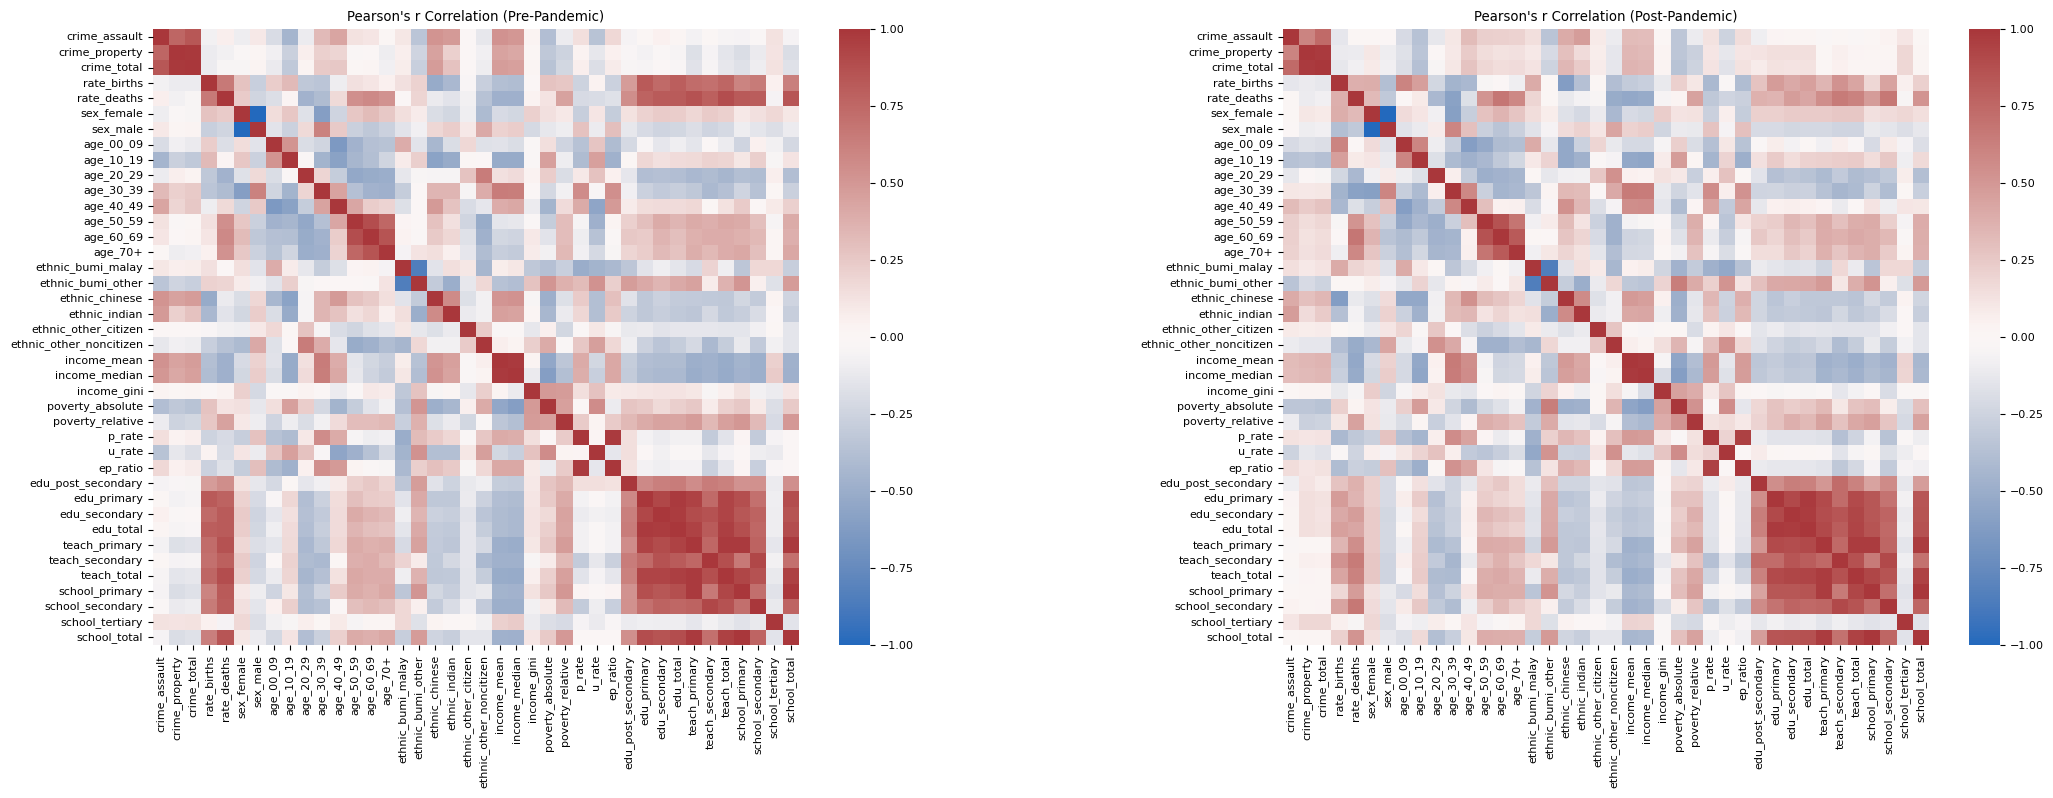

In [27]:
# Create correlation matrix. Use: Pearson's r
dfPre_corr = dfPre.drop(dfPre.columns[dfPre.columns.str.startswith('crime_assault_') + dfPre.columns.str.startswith('crime_property_') + dfPre.columns.str.startswith('population')], axis=1).corr()
dfPost_corr = dfPost.drop(dfPost.columns[dfPost.columns.str.startswith('crime_assault_') + dfPost.columns.str.startswith('crime_property_') + dfPost.columns.str.startswith('population')], axis=1).corr()

fig, axs = plt.subplots(1,2, figsize=(25,8))
plt.subplots_adjust(wspace=0.4)

sns.heatmap(dfPre_corr,
            vmin=-1, vmax=1, center=0, cmap='vlag', ax=axs[0])
axs[0].set_title("Pearson's r Correlation (Pre-Pandemic)")

sns.heatmap(dfPost_corr,
            vmin=-1, vmax=1, center=0, cmap='vlag', ax=axs[1])
axs[1].set_title("Pearson's r Correlation (Post-Pandemic)")

plt.show()

### B.2. Crime-related Focus Correlation Matrix

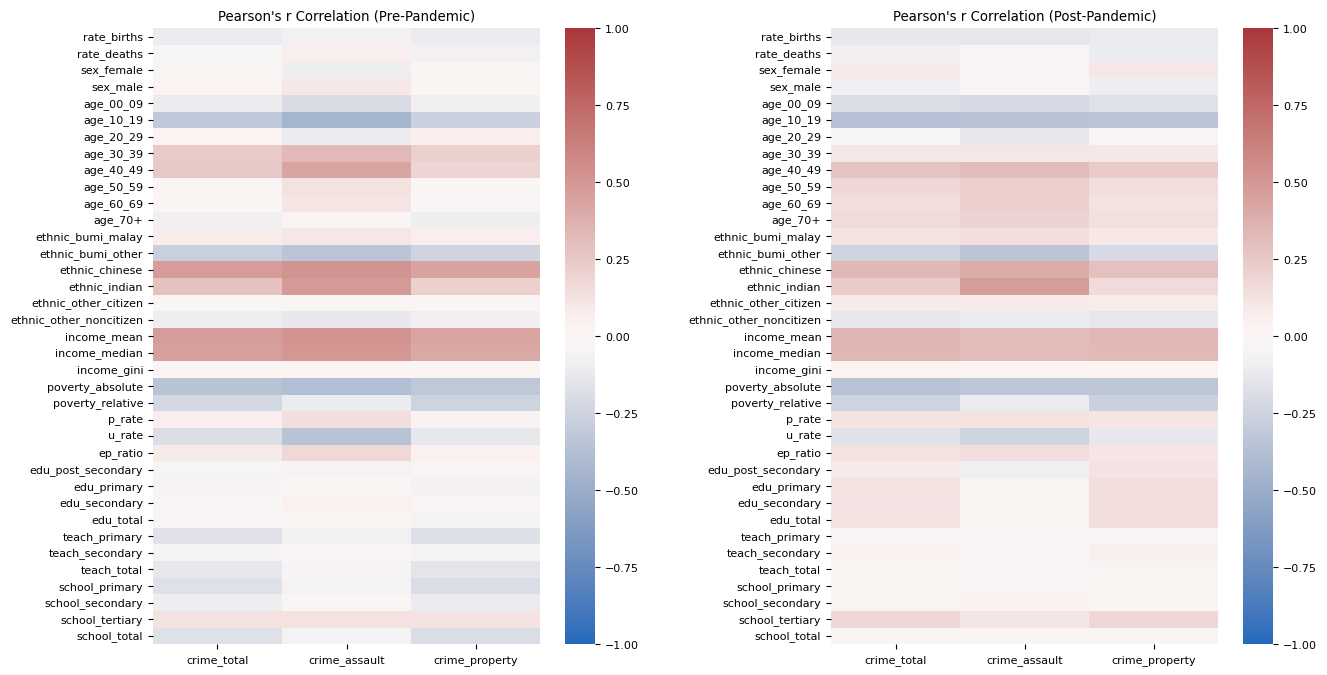

In [6]:
# Plot correlation matrix for crime variables
dfPre_corr_crime = dfPre_corr[['crime_total', 'crime_assault', 'crime_property']].drop(list(dfPre_corr.columns[dfPre_corr.columns.str.startswith("crime")].values))
dfPost_corr_crime = dfPost_corr[['crime_total', 'crime_assault', 'crime_property']].drop(list(dfPost_corr.columns[dfPost_corr.columns.str.startswith("crime")].values))

fig, axs = plt.subplots(1,2, figsize=(15,8))
plt.subplots_adjust(wspace=0.4)

sns.heatmap(dfPre_corr_crime,
            vmin=-1, vmax=1, center=0, cmap='vlag', ax=axs[0])
axs[0].set_title("Pearson's r Correlation (Pre-Pandemic)")

sns.heatmap(dfPost_corr_crime,
            vmin=-1, vmax=1, center=0, cmap='vlag', ax=axs[1])
axs[1].set_title("Pearson's r Correlation (Post-Pandemic)")

plt.show()

## C. Analyse 2D Embedding

### C.1. Pre-process Data
Embed using only columns with high correlation.

In [7]:
# Identify columns to keep.
col_to_keep = dfPreTotal.columns.str.startswith('age') + dfPreTotal.columns.str.startswith('ethnic_bumi') + dfPreTotal.columns.isin(['ethnic_chinese', 'ethnic_indian', 'income_mean', 'income_median'])
col_to_keep = col_to_keep + dfPreTotal.columns.str.startswith('poverty') + dfPreTotal.columns.isin(['school_primary', 'school_secondary'])

# Implement MDS
dfPreTotal_mds2 = do_mds(dfPreTotal[dfPreTotal.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)
dfPostTotal_mds2 = do_mds(dfPostTotal[dfPostTotal.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)
dfPreAssault_mds2 = do_mds(dfPreAssault[dfPreAssault.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)
dfPostAssault_mds2 = do_mds(dfPostAssault[dfPostAssault.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)
dfPreProperty_mds2 = do_mds(dfPreProperty[dfPreProperty.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)
dfPostProperty_mds2 = do_mds(dfPostProperty[dfPostProperty.columns[col_to_keep]], r_state=42, p_n_init=2500, p_max_iter=10000)

# Create quintile columns
dfPreTotal_mds2 = dfPreTotal_mds2.merge(pd.DataFrame(pd.qcut(dfPre['crime_total'], q=5, labels=False)).rename(columns={'crime_total':'quintile'}), left_index=True, right_index=True)
dfPostTotal_mds2 = dfPostTotal_mds2.merge(pd.DataFrame(pd.qcut(dfPost['crime_total'], q=5, labels=False)).rename(columns={'crime_total':'quintile'}), left_index=True, right_index=True)
dfPreAssault_mds2 = dfPreAssault_mds2.merge(pd.DataFrame(pd.qcut(dfPre['crime_assault'], q=5, labels=False)).rename(columns={'crime_assault':'quintile'}), left_index=True, right_index=True)
dfPostAssault_mds2 = dfPostAssault_mds2.merge(pd.DataFrame(pd.qcut(dfPost['crime_assault'], q=5, labels=False)).rename(columns={'crime_assault':'quintile'}), left_index=True, right_index=True)
dfPreProperty_mds2 = dfPreProperty_mds2.merge(pd.DataFrame(pd.qcut(dfPre['crime_property'], q=5, labels=False)).rename(columns={'crime_property':'quintile'}), left_index=True, right_index=True)
dfPostProperty_mds2 = dfPostProperty_mds2.merge(pd.DataFrame(pd.qcut(dfPost['crime_property'], q=5, labels=False)).rename(columns={'crime_property':'quintile'}), left_index=True, right_index=True)

### C.2. Visualise Embedding Results

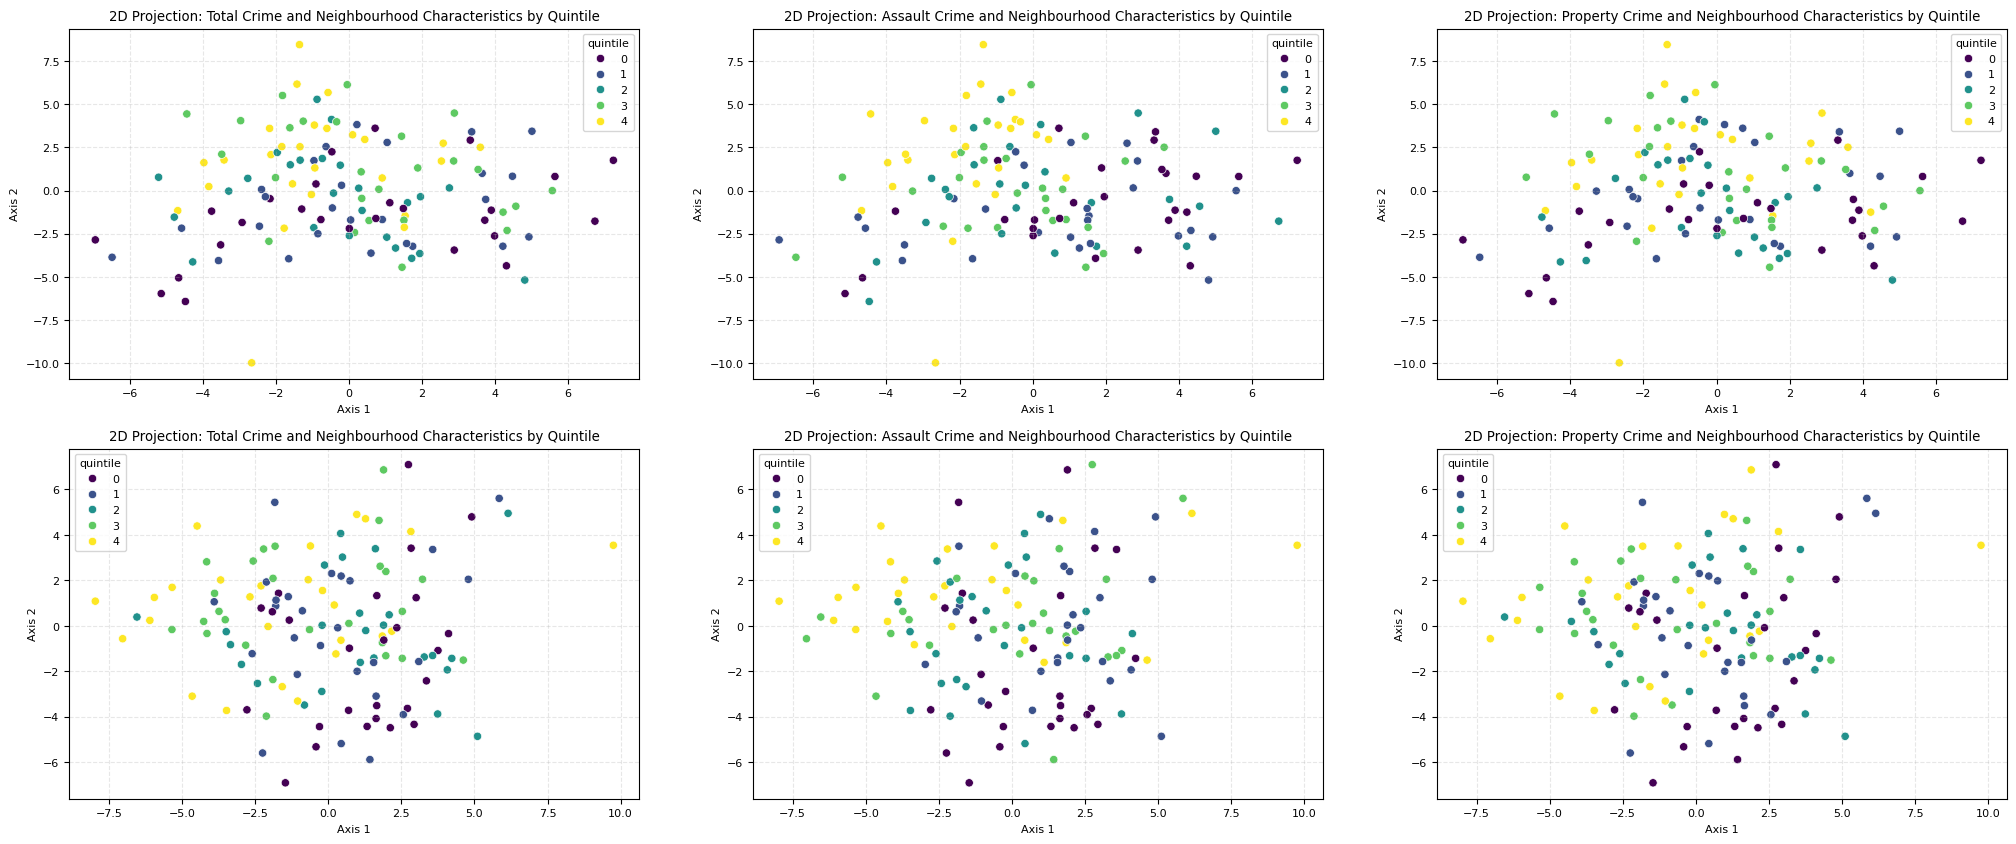

In [8]:
# Visualise MDS results
fig, axs = plt.subplots(2,3, figsize=(25,10))

sns.scatterplot(dfPreTotal_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[0,0])
axs[0,0].set_title("2D Projection: Total Crime and Neighbourhood Characteristics by Quintile")

sns.scatterplot(dfPreAssault_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[0,1])
axs[0,1].set_title("2D Projection: Assault Crime and Neighbourhood Characteristics by Quintile")

sns.scatterplot(dfPreProperty_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[0,2])
axs[0,2].set_title("2D Projection: Property Crime and Neighbourhood Characteristics by Quintile")

sns.scatterplot(dfPostTotal_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[1,0])
axs[1,0].set_title("2D Projection: Total Crime and Neighbourhood Characteristics by Quintile")

sns.scatterplot(dfPostAssault_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[1,1])
axs[1,1].set_title("2D Projection: Assault Crime and Neighbourhood Characteristics by Quintile")

sns.scatterplot(dfPostProperty_mds2, x='xy_mds1', y='xy_mds2', hue='quintile', palette='viridis', ax=axs[1,2])
axs[1,2].set_title("2D Projection: Property Crime and Neighbourhood Characteristics by Quintile")

for i in range(2):
    for j in range(3):
        axs[i,j].set_xlabel("Axis 1")
        axs[i,j].set_ylabel("Axis 2")
        axs[i,j].grid(linestyle='--', alpha=0.3)

plt.show()

## D. Analyse Neighbourhood Characteristics Based on Cluster Derived in RQ2

In [20]:
ClusterCrime2023_v2 = pd.read_csv("data/1_ClusterCrime2023.csv")
dfPost_cc23 = dfPost.merge(ClusterCrime2023_v2.set_index(['location', 'state', 'district']).crime_level.astype(int), left_index=True, right_index=True)
dfPost_cc23 = dfPost_cc23.rename({'crime_level':'label'}, axis=1)
dfPost_cc23 = dfPost_cc23[dfPost_cc23['label'] != -1]

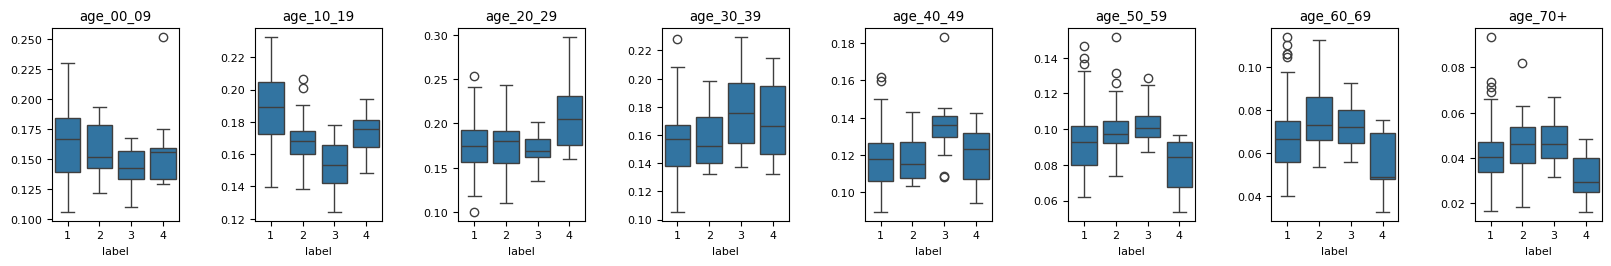

In [21]:
fig, axs = plt.subplots(1,8, figsize=(20,2.5))
plt.subplots_adjust(wspace=0.6)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('age')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i])
    axs[i].set_ylabel("")
    axs[i].set_title(col)

plt.show()

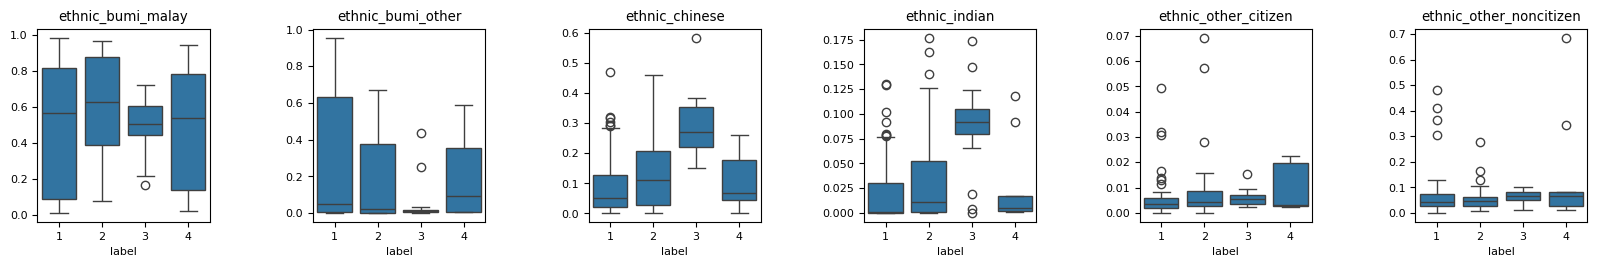

In [22]:
fig, axs = plt.subplots(1,6, figsize=(20,2.5))
plt.subplots_adjust(wspace=0.6)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('ethnic')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i])
    axs[i].set_ylabel("")
    axs[i].set_title(col)

plt.show()

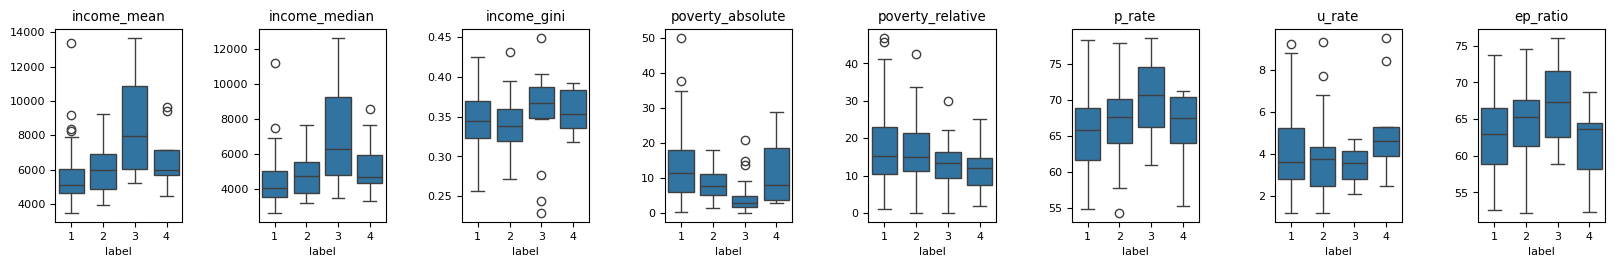

In [23]:
fig, axs = plt.subplots(1,8, figsize=(20,2.5))
plt.subplots_adjust(wspace=0.6)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('income')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i])
    axs[i].set_ylabel("")
    axs[i].set_title(col)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('poverty')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i+3])
    axs[i+3].set_ylabel("")
    axs[i+3].set_title(col)

sns.boxplot(data=dfPost_cc23, x='label', y='p_rate', ax=axs[5])
axs[5].set_ylabel("")
axs[5].set_title('p_rate')

sns.boxplot(data=dfPost_cc23, x='label', y='u_rate', ax=axs[6])
axs[6].set_ylabel("")
axs[6].set_title('u_rate')

sns.boxplot(data=dfPost_cc23, x='label', y='ep_ratio', ax=axs[7])
axs[7].set_ylabel("")
axs[7].set_title('ep_ratio')

plt.show()

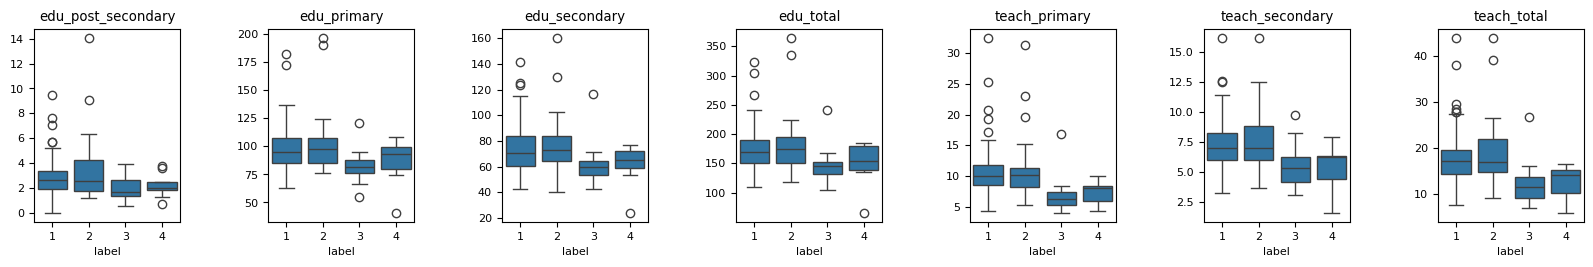

In [24]:
fig, axs = plt.subplots(1,7, figsize=(20,2.5))
plt.subplots_adjust(wspace=0.6)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('edu')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i])
    axs[i].set_ylabel("")
    axs[i].set_title(col)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('teach')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i+4])
    axs[i+4].set_ylabel("")
    axs[i+4].set_title(col)

plt.show()

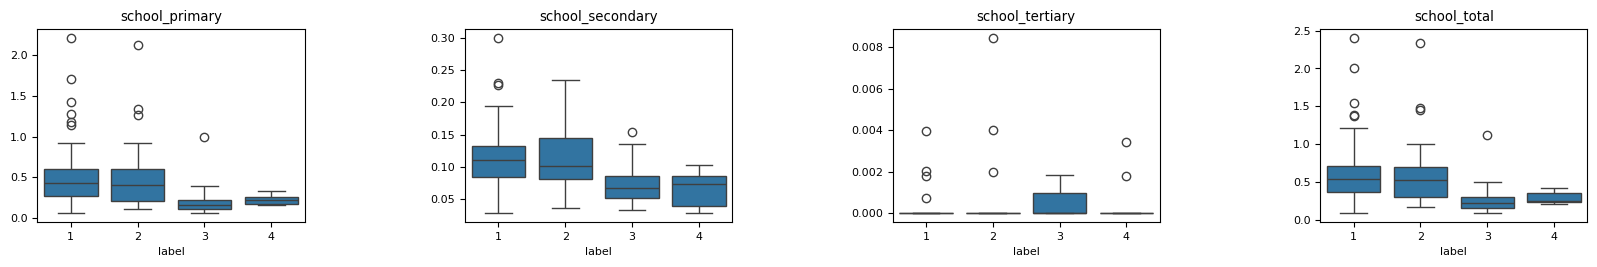

In [25]:
fig, axs = plt.subplots(1,4, figsize=(20,2.5))
plt.subplots_adjust(wspace=0.6)

for i, col in enumerate(dfPost_cc23.columns[dfPost_cc23.columns.str.startswith('school')]):
    sns.boxplot(data=dfPost_cc23, x='label', y=col, ax=axs[i])
    axs[i].set_ylabel("")
    axs[i].set_title(col)

plt.show()